In [1]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from influx import query_batch, convert

from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn as tflearn
from tensorflow.contrib import layers as tflayers

from sklearn.metrics import mean_squared_error


In [3]:
def model(X, y):
    basics = [tf.nn.rnn_cell.BasicLSTMCell(5, state_is_tuple=True)]
    stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(basics, state_is_tuple=True)
    x_ = tf.unpack(X, axis=1, num=10)
    output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
    output = tflayers.stack(output[-1], tflayers.fully_connected, [10, 10])
    prediction, loss = tflearn.models.linear_regression(output, y)
    train_op = tf.contrib.layers.optimize_loss(
                loss, tf.contrib.framework.get_global_step(), optimizer='Adagrad',
                learning_rate=0.1)
    return prediction, loss, train_op

In [4]:
def influx(db, query, column):
    for res in query_batch(query, limit=11, offset=0, db=db):
        for s in convert(res.raw):
            v = np.array(s.feature_lists.feature_list[column].feature[0].float_list.value, dtype=np.float32)
            data = np.zeros((10,), dtype=np.float32)
            data[:v.shape[0]-1] = v[:v.shape[0]-1]
            data = np.array(data).reshape([10, -1]) 
            target = np.array(v[-1])
            yield data, target

In [5]:
with tf.Session() as sess:
    db = "tensorflowdb"
    query = "select wet_bulb_temp from qclcd where wban = '14920' and time > now() - 30d group by wban"
    column = "column/wet_bulb_temp"
    regressor = tflearn.SKCompat(tflearn.Estimator(model_fn=model))

    inputs = []
    targets = []
    for data, target in influx(db, query, column):
        inputs.append(data)
        targets.append(target)

    inputs = np.array(inputs)
    targets = np.array(targets)
    regressor.fit(inputs, targets, batch_size=20, steps=20)
    predicted = regressor.predict(inputs)
    #not used in this example but used for seeing deviations
    rmse = np.sqrt(((predicted - targets) ** 2).mean(axis=0))

    score = mean_squared_error(predicted, targets)
    print ("MSE: %f" % score)

MSE: 66.719292


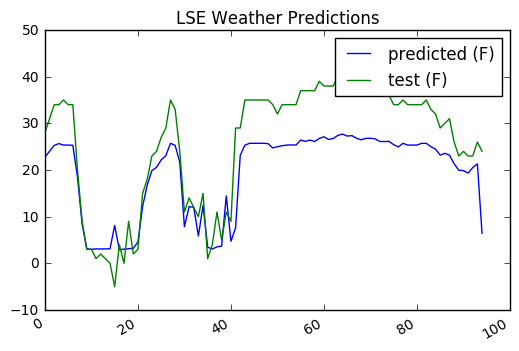

In [8]:
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

predicted_values = predicted.flatten()
plot_predicted, = ax.plot(predicted_values, label='predicted (F)')

test_values = targets.flatten()
plot_test, = ax.plot(test_values, label='test (F)')

plt.title('LSE Weather Predictions')
plt.legend(handles=[plot_predicted, plot_test])
plt.show()